# Linear Regression and Gradient Descent

In this notebook we will see how we can perform linear regression in three different ways: 
1. pure numpy
2. numpy + pytorch's autograd 
3. pure pytorch

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from IPython.core.debugger import set_trace

In [4]:
np.random.seed(0)
torch.manual_seed(0)

# The Problem

(100, 1) (100,)


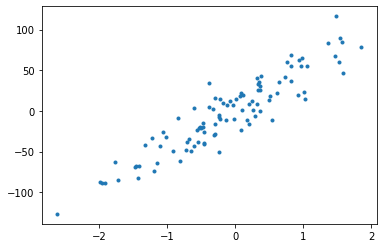

In [99]:
from sklearn.datasets import make_regression


n_features = 1
n_samples = 100

X, y = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    noise=20,
    random_state=42,
)

fix, ax = plt.subplots()
ax.plot(X, y, ".")
print(X.shape, y.shape)

# Numpy Solution

In [270]:
class LinearRegression(object):
    def __init__(self, n_features, n_targets=1, lr=0.1):
        self.W = np.zeros((n_targets, n_features))
        self.lr = lr

    def update_weight(self, X, y):
        m = X.shape[0]
        y_hat = self.predict(X)
        W_grad = 2 * np.dot(X.T, y_hat - y) / m
        self.W = self.W - self.lr * W_grad

    def loss(self, y_hat, y):
        return np.mean(np.power(y_hat - y, 2))

    def predict(self, X):
        y_hat = np.dot(X, self.W.T)
        return y_hat.squeeze(-1)

    def train(self, X, y, epochs=50):
        """
        X (n_examples x n_features):
        y (n_examples): gold labels
        """
        loss_history = []
        for _ in range(epochs):
            # for x_i, y_i in zip(X, y):
            #        self.update_weight(x_i, y_i)
            self.update_weight(X, y)
            y_hat = self.predict(X)
            loss = self.loss(y_hat, y)
            loss_history.append(loss)
        return loss_history

In [240]:
use_bias = False
if use_bias:
    X_np = np.hstack([np.ones((n_samples,1)), X])
    n_features += 1
else:
    X_np = X

In [267]:
model = LinearRegression(n_features=n_features, n_targets=1, lr=0.1)
loss_history = model.train(X_np, y, epochs=50)
y_hat = model.predict(X_np)

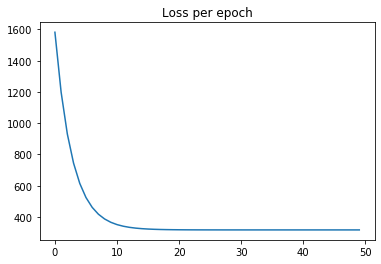

In [268]:
plt.plot(loss_history)
plt.title('Loss per epoch');

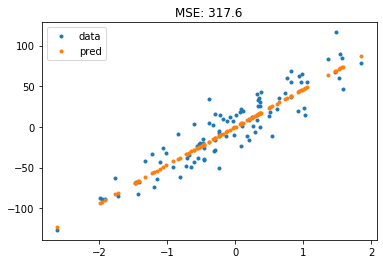

In [269]:
# Vis
fig, ax = plt.subplots()
ax.plot(X, y, ".", label="data")
ax.plot(X, y_hat, ".", label="pred")
ax.set_title(f"MSE: {loss_history[-1]:0.1f}")
ax.legend();

# Numpy + Autograd Solution

In [277]:
class MixedLinearRegression(object):
    def __init__(self, n_features, n_targets=1, lr=0.01):
        self.W = torch.zeros(n_targets, n_features, requires_grad=True)  # note requires_grad=True!
        self.lr = lr
    
    def update_weight(self):
        # Gradients are given to us by autograd!
        self.W.data = self.W.data - self.lr * self.W.grad.data

    def loss(self, y_hat, y):
        return torch.mean(torch.pow(y_hat - y, 2))

    def predict(self, X):
        y_hat = torch.matmul(X, self.W.t())
        return y_hat.squeeze(-1)

    def train(self, X, y, epochs=50):
        """
        X (n_examples x n_features):
        y (n_examples): gold labels
        """
        loss_history = []
        for _ in range(epochs):
            
            # Our neural net is a Line function!
            y_hat = self.predict(X)
            
            # Compute the loss using torch operations so they are saved in the gradient history.
            loss = self.loss(y_hat, y)
            
            # Computes the gradient of loss with respect to all Variables with requires_grad=True.
            loss.backward()
            loss_history.append(loss.item())

            # Update a and b using gradient descent; a.data and b.data are Tensors.
            self.update_weight()

            # Reset the accumulated gradients
            self.W.grad.data.zero_()
            
        return loss_history

In [278]:
X_pt = torch.from_numpy(X_np).float()
y_pt = torch.from_numpy(y).float()

In [279]:
model = MixedLinearRegression(n_features=n_features, n_targets=1, lr=0.1)
loss_history = model.train(X_pt, y_pt, epochs=50)
with torch.no_grad():
    y_hat = model.predict(X_pt)

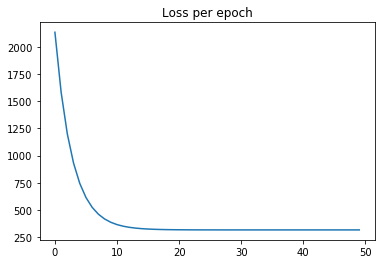

In [280]:
plt.plot(loss_history)
plt.title('Loss per epoch');

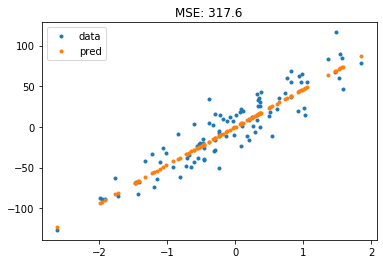

In [281]:
# Vis
fig, ax = plt.subplots()
ax.plot(X_pt.cpu().numpy(), y_pt.cpu().numpy(), ".", label="data")
ax.plot(X_pt.cpu().numpy(), y_hat.cpu().numpy(), ".", label="pred")
ax.set_title(f"MSE: {loss_history[-1]:0.1f}")
ax.legend();

# PyTorch Solution

In [282]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y.reshape((n_samples, n_features))).float()

In [290]:
class LinReg(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.beta = nn.Linear(input_dim, 1)

    def forward(self, X):
        return self.beta(X)

In [284]:
# define model, loss function and optmizer
model = LinReg(n_features).to(DEVICE)  # <-- here
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# move to CUDA if available
X, y = X.to(DEVICE), y.to(DEVICE)  # <-- here

In [285]:
def train(model, X, y, epochs=50):
    model.train()  # <-- here
    loss_history = []
    for _ in range(epochs):
        optimizer.zero_grad()

        y_ = model(X)
        loss = loss_fn(y_, y)
        
        loss_history.append(loss.item())

        loss.backward()
        optimizer.step()

    return loss_history

In [286]:
def evaluate(model, X):
    model.eval()  # <-- here
    with torch.no_grad():
        y_ = model(X)    
    return y_

In [287]:
loss_history = train(model, X, y, epochs=50)
y_hat = evaluate(model, X)

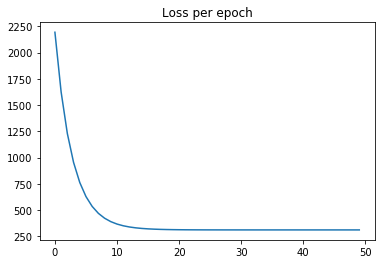

In [288]:
plt.plot(loss_history)
plt.title('Loss per epoch');

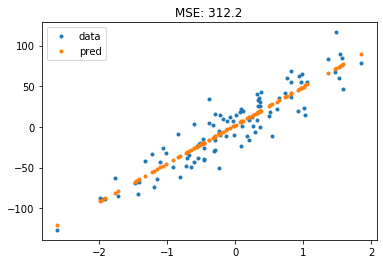

In [289]:
# Vis
fig, ax = plt.subplots()
ax.plot(X.cpu().numpy(), y.cpu().numpy(), ".", label="data")
ax.plot(X.cpu().numpy(), y_hat.cpu().numpy(), ".", label="pred")
ax.set_title(f"MSE: {loss_history[-1]:0.1f}")
ax.legend();

Note: I did gradient descent with all the data. I did not split the data into `train` and `valid` which should be done!

## Exercise

- Write a proper training loop for PyTorch.